# Sequential Gaussian simulation
#### Mickey MacKie, Stanford Radio Glaciology

We perform a sequential Gaussian simulation, a common method for stochastic simulation.

In [1]:
# load dependencies
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from sklearn.neighbors import LocalOutlierFactor
import geostatspy.geostats as geostats 

import GlacierStats as gs

import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

## Load and plot data

In [2]:
df_bed = pd.read_csv('Data/Nioghalvfjerds_bed_data.csv') # download data

# remove outliers with LOF method
clf = LocalOutlierFactor(n_neighbors = 5, contamination = 0.05)
clf.fit_predict(df_bed)
lof = clf.negative_outlier_factor_
df_bed = df_bed[lof >= -1.3]

<function matplotlib.pyplot.show(*args, **kw)>

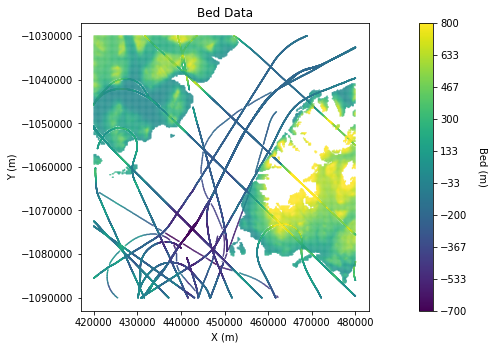

In [3]:
# plot data
im = plt.scatter(df_bed['X'],df_bed['Y'], c = df_bed['Bed'], vmin = -700, vmax = 800, marker=".", s = 0.5)       # scatter plot for location map
plt.title('Bed Data')                                    # add plot title
plt.xlabel('X (m)'); plt.ylabel('Y (m)')                          # set axis labels
cbar = plt.colorbar(im, orientation="vertical", ticks=np.linspace(-700, 800, 10)) # add vertical color bar
cbar.set_label("Bed (m)", rotation=270, labelpad=20)      # add labels to the color bar
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0) # adjust the plot size
plt.axis('scaled')
plt.show

## Convert to standard Gaussian distribution

In [4]:
df_bed['Nbed'], tvbed, tnsbed = geostats.nscore(df_bed,'Bed')  # normal score transformation

## Set variogram parameters

These are the variogram model parameters we determined in Variogram_model.ipynb:

In [5]:
Azimuth = 22.5 # azimuthal direction of major axis
nug = 0 # nugget
nstruct = 2 # variogram structures
vtype = [1,2] # exponential type (1 = spherical, 2 = exponential, 3 = Guassian)
cc = [0.8,0.2] # contribution for each structure. nugget + cc = 1
a_max = [40000,50000] # major range for each structure
a_min = [25000,30000] # minor range for each structure

vario = [Azimuth, nug, nstruct, vtype, cc, a_max, a_min] # save variogram parameters as a list

## Sequential Gaussian simulation

First we need to define a grid to interpolate:

In [6]:
# define coordinate grid
xmin = 420000; xmax = 480000              # range of x values
ymin = -1090000; ymax = -1030000     # range of y values
pix = 500  # pixel resolution
Pred_grid_xy = gs.pred_grid(xmin, xmax, ymin, ymax, pix)

In [7]:
# randomly downsample data to 10% of the original size
df_samp = df_bed.sample(frac=0.10, replace=False, random_state=1)

In [8]:
k = 50 # number of neighboring data points used to estimate a given point 
sgs = gs.sgsim(Pred_grid_xy, df_samp, 'X', 'Y', 'Nbed', k, vario) # simulate

100%|██████████| 14400/14400 [02:20<00:00, 102.81it/s]


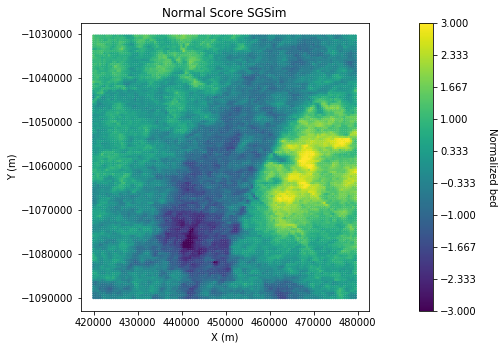

In [9]:
# plot results
im = plt.scatter(Pred_grid_xy[:,0], Pred_grid_xy[:,1], c = sgs, vmin = -3, vmax = 3, marker=".", s = 15)       # scatter plot for location map
plt.title('Normal Score SGSim')                                    # add plot title
plt.xlabel('X (m)'); plt.ylabel('Y (m)')                          # set axis labels
cbar = plt.colorbar(im, orientation="vertical", ticks=np.linspace(-3, 3, 10)) # add vertical color bar
cbar.set_label("Normalized bed", rotation=270, labelpad=20)      # add labels to the color bar
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0) # adjust the plot size
plt.axis('scaled')
plt.show()

Reverse normal score transformation

In [10]:
# create dataframe for back transform function
df_sgs = pd.DataFrame(sgs, columns = ['sgs'])

# transformation parameters
vr = tvbed
vrg = tnsbed
ltail = 1
utail = 1
zmin = -4
zmax = 4
ltpar = -1000
utpar = 1000

# transformation
sgs_trans = geostats.backtr(df_sgs,'sgs',vr,vrg,zmin,zmax,ltail,ltpar,utail,utpar)

Let's plot a hillshade version so we can appreciate the topographic textures

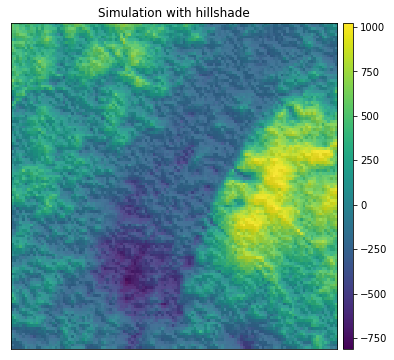

In [11]:
# make hillshade plot

# reshape grid
ylen = (ymax - ymin)/pix
xlen = (xmax - xmin)/pix
elevation = np.reshape(sgs_trans, (int(ylen), int(xlen)))

hillshade = es.hillshade(elevation, azimuth = 210, altitude = 10) # hillshade

fig, ax = plt.subplots(figsize=(10, 6))
ep.plot_bands(
    elevation,
    ax=ax,
    cmap="viridis",
    title="Simulation with hillshade",
)
ax.imshow(hillshade, cmap="Greys", alpha=0.1)
plt.show()

Awesome! We've created a geologically realistic digital elevation model. Let's imagine we wanted to generate multiple realizations for some kind of Bayesian analysis. To do that, we would generate simulations in a for loop, where on each iteration, we would randomly downsample a different subset of the data:

In [12]:
 # multiple realizations
     
num_sim = 2 # number of realizations
sgs_mult = np.zeros((num_sim, len(Pred_grid_xy))) # preallocate space for simulations

# let it rip
for i in range(0, num_sim):

    # randomly downsample data to 10% of the original size
    df_samp = df_bed.sample(frac=0.10, replace=False, random_state=1)
    
    sgs_mult[i,:] = gs.sgsim(Pred_grid_xy, df_samp, 'X', 'Y', 'Nbed', k, vario) # simulate

100%|██████████| 14400/14400 [02:56<00:00, 81.60it/s]


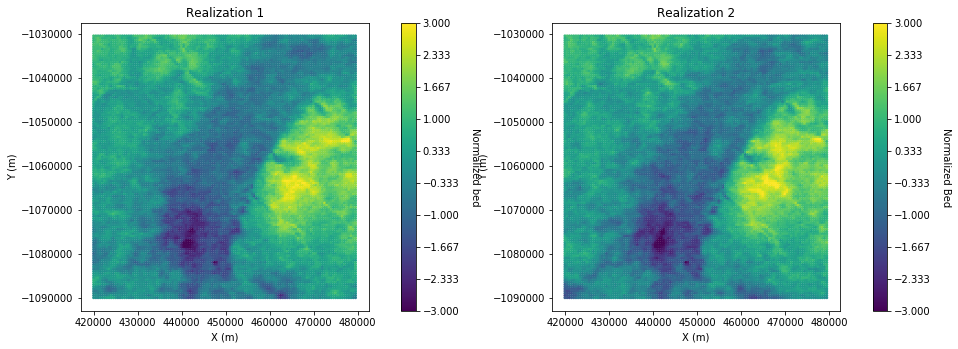

In [13]:
# plot realizations

plt.subplot(121) 
im = plt.scatter(Pred_grid_xy[:,0],Pred_grid_xy[:,1], c = sgs_mult[0,:], vmin = -3, vmax = 3, marker=".", s = 15)       # scatter plot for location map
plt.title('Realization 1')                                    # add plot title
plt.xlabel('X (m)'); plt.ylabel('Y (m)')                          # set axis labels
cbar = plt.colorbar(im, orientation="vertical", ticks=np.linspace(-3, 3, 10)) # add vertical color bar
cbar.set_label("Normalized bed", rotation=270, labelpad=20)      # add labels to the color bar
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0) # adjust the plot size
plt.axis('scaled')

plt.subplot(122) 
im = plt.scatter(Pred_grid_xy[:,0],Pred_grid_xy[:,1], c = sgs_mult[1,:], vmin = -3, vmax = 3, marker=".", s = 15)       # scatter plot for location map
plt.title('Realization 2')                                    # add plot title
plt.xlabel('X (m)'); plt.ylabel('Y (m)')                          # set axis labels
cbar = plt.colorbar(im, orientation="vertical", ticks=np.linspace(-3, 3, 10)) # add vertical color bar
cbar.set_label("Normalized Bed", rotation=270, labelpad=20)      # add labels to the color bar
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0) # adjust the plot size
plt.axis('scaled')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.3)
plt.show()